In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e21/sample_submission.csv


* [EDA](#chapter1)
    * [Imports](#subsection1)
* [Feature Engineering](#chapter2)
    * [Section 3.1](#section_3_1)

# EDA <a class="anchor"  id="chapter1"></a>

## Imports <a class="anchor"  id="subsection1"></a>

In [2]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler
from IPython.display import display
from pandas.api.types import CategoricalDtype
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDOneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from matplotlib.ticker import MaxNLocator
from functools import partial
import scipy.stats

from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Config

In [3]:
TARGET = 'target'
RESULT_BASELINE = []

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_20/3472649638.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Load data

In [4]:
# Read the data
train = pd.read_csv("/kaggle/input/playground-series-s3e21/sample_submission.csv")

## Data Statistics

In [5]:
train.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [6]:
train.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,1749.500000,8.473834,8.216993,9.291581,9.633064,8.065733,5.671581,9.461363,6.547433,0.340525,...,8.710466,3.002243,3.242654,4.816718,4.754389,4.285660,5.968980,7.837995,3.750349,4.068639
std,1010.507298,1.885712,3.040743,6.817822,1.439039,1.463881,2.721399,1.140365,1.663266,0.284751,...,6.438648,2.918355,2.713923,2.009161,1.547491,2.093388,2.576146,3.724861,1.682421,1.894632
min,0.000000,1.300000,0.000000,0.000000,4.900000,2.300000,0.200000,0.000000,0.000000,0.020000,...,0.044000,0.011000,0.000000,0.570000,0.089000,0.850000,2.025000,2.020000,0.364000,1.600000
25%,874.750000,7.470000,7.100000,7.300000,8.770000,6.830000,4.550000,8.980000,5.877500,0.214500,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.684000,2.900000
50%,1749.500000,8.280000,7.890000,8.300000,9.500000,7.980000,5.800000,9.430000,6.430000,0.247000,...,6.054000,1.730000,1.800000,4.600000,4.800000,3.950000,5.725000,7.500000,3.500000,3.700000
75%,2624.250000,9.110000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,...,14.515000,3.025000,4.237500,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000
max,3499.000000,65.930000,46.950000,65.950000,16.900000,21.800000,59.400000,40.190000,15.900000,4.200000,...,35.000000,19.355000,27.025000,11.650000,10.700000,19.800000,55.400000,82.450000,19.375000,10.370000


In [7]:
[train.shape]

[(3500, 37)]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3500 non-null   int64  
 1   target  3500 non-null   float64
 2   O2_1    3500 non-null   float64
 3   O2_2    3500 non-null   float64
 4   O2_3    3500 non-null   float64
 5   O2_4    3500 non-null   float64
 6   O2_5    3500 non-null   float64
 7   O2_6    3500 non-null   float64
 8   O2_7    3500 non-null   float64
 9   NH4_1   3500 non-null   float64
 10  NH4_2   3500 non-null   float64
 11  NH4_3   3500 non-null   float64
 12  NH4_4   3500 non-null   float64
 13  NH4_5   3500 non-null   float64
 14  NH4_6   3500 non-null   float64
 15  NH4_7   3500 non-null   float64
 16  NO2_1   3500 non-null   float64
 17  NO2_2   3500 non-null   float64
 18  NO2_3   3500 non-null   float64
 19  NO2_4   3500 non-null   float64
 20  NO2_5   3500 non-null   float64
 21  NO2_6   3500 non-null   float64
 22  

In [9]:
num_col = train.select_dtypes(exclude=['object'])#.drop([TARGET], axis=1).copy()
cat_col = train.select_dtypes(include=['object'])
ord_col = []
all_col = [f for f in train.columns if f != TARGET]

In [10]:
print(num_col.columns)
print(cat_col.columns)

Index(['id', 'target', 'O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7',
       'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1',
       'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_2',
       'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_1', 'BOD5_2',
       'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],
      dtype='object')
Index([], dtype='object')


## Understand data

## Univariate analysis

### Numeric features

For numerical features, we are always concerned about the distribution of these features, including the statistical characteristics of these columns e.g mean, median, mode. Hence we will usually use Distribution plot to visualize their data distribution. Boxplots are also commonly used to unearth the statistical characteristics of each feature. More often than not, we use it to look for any outliers that we might need to filter out later on during the preprocessing step.

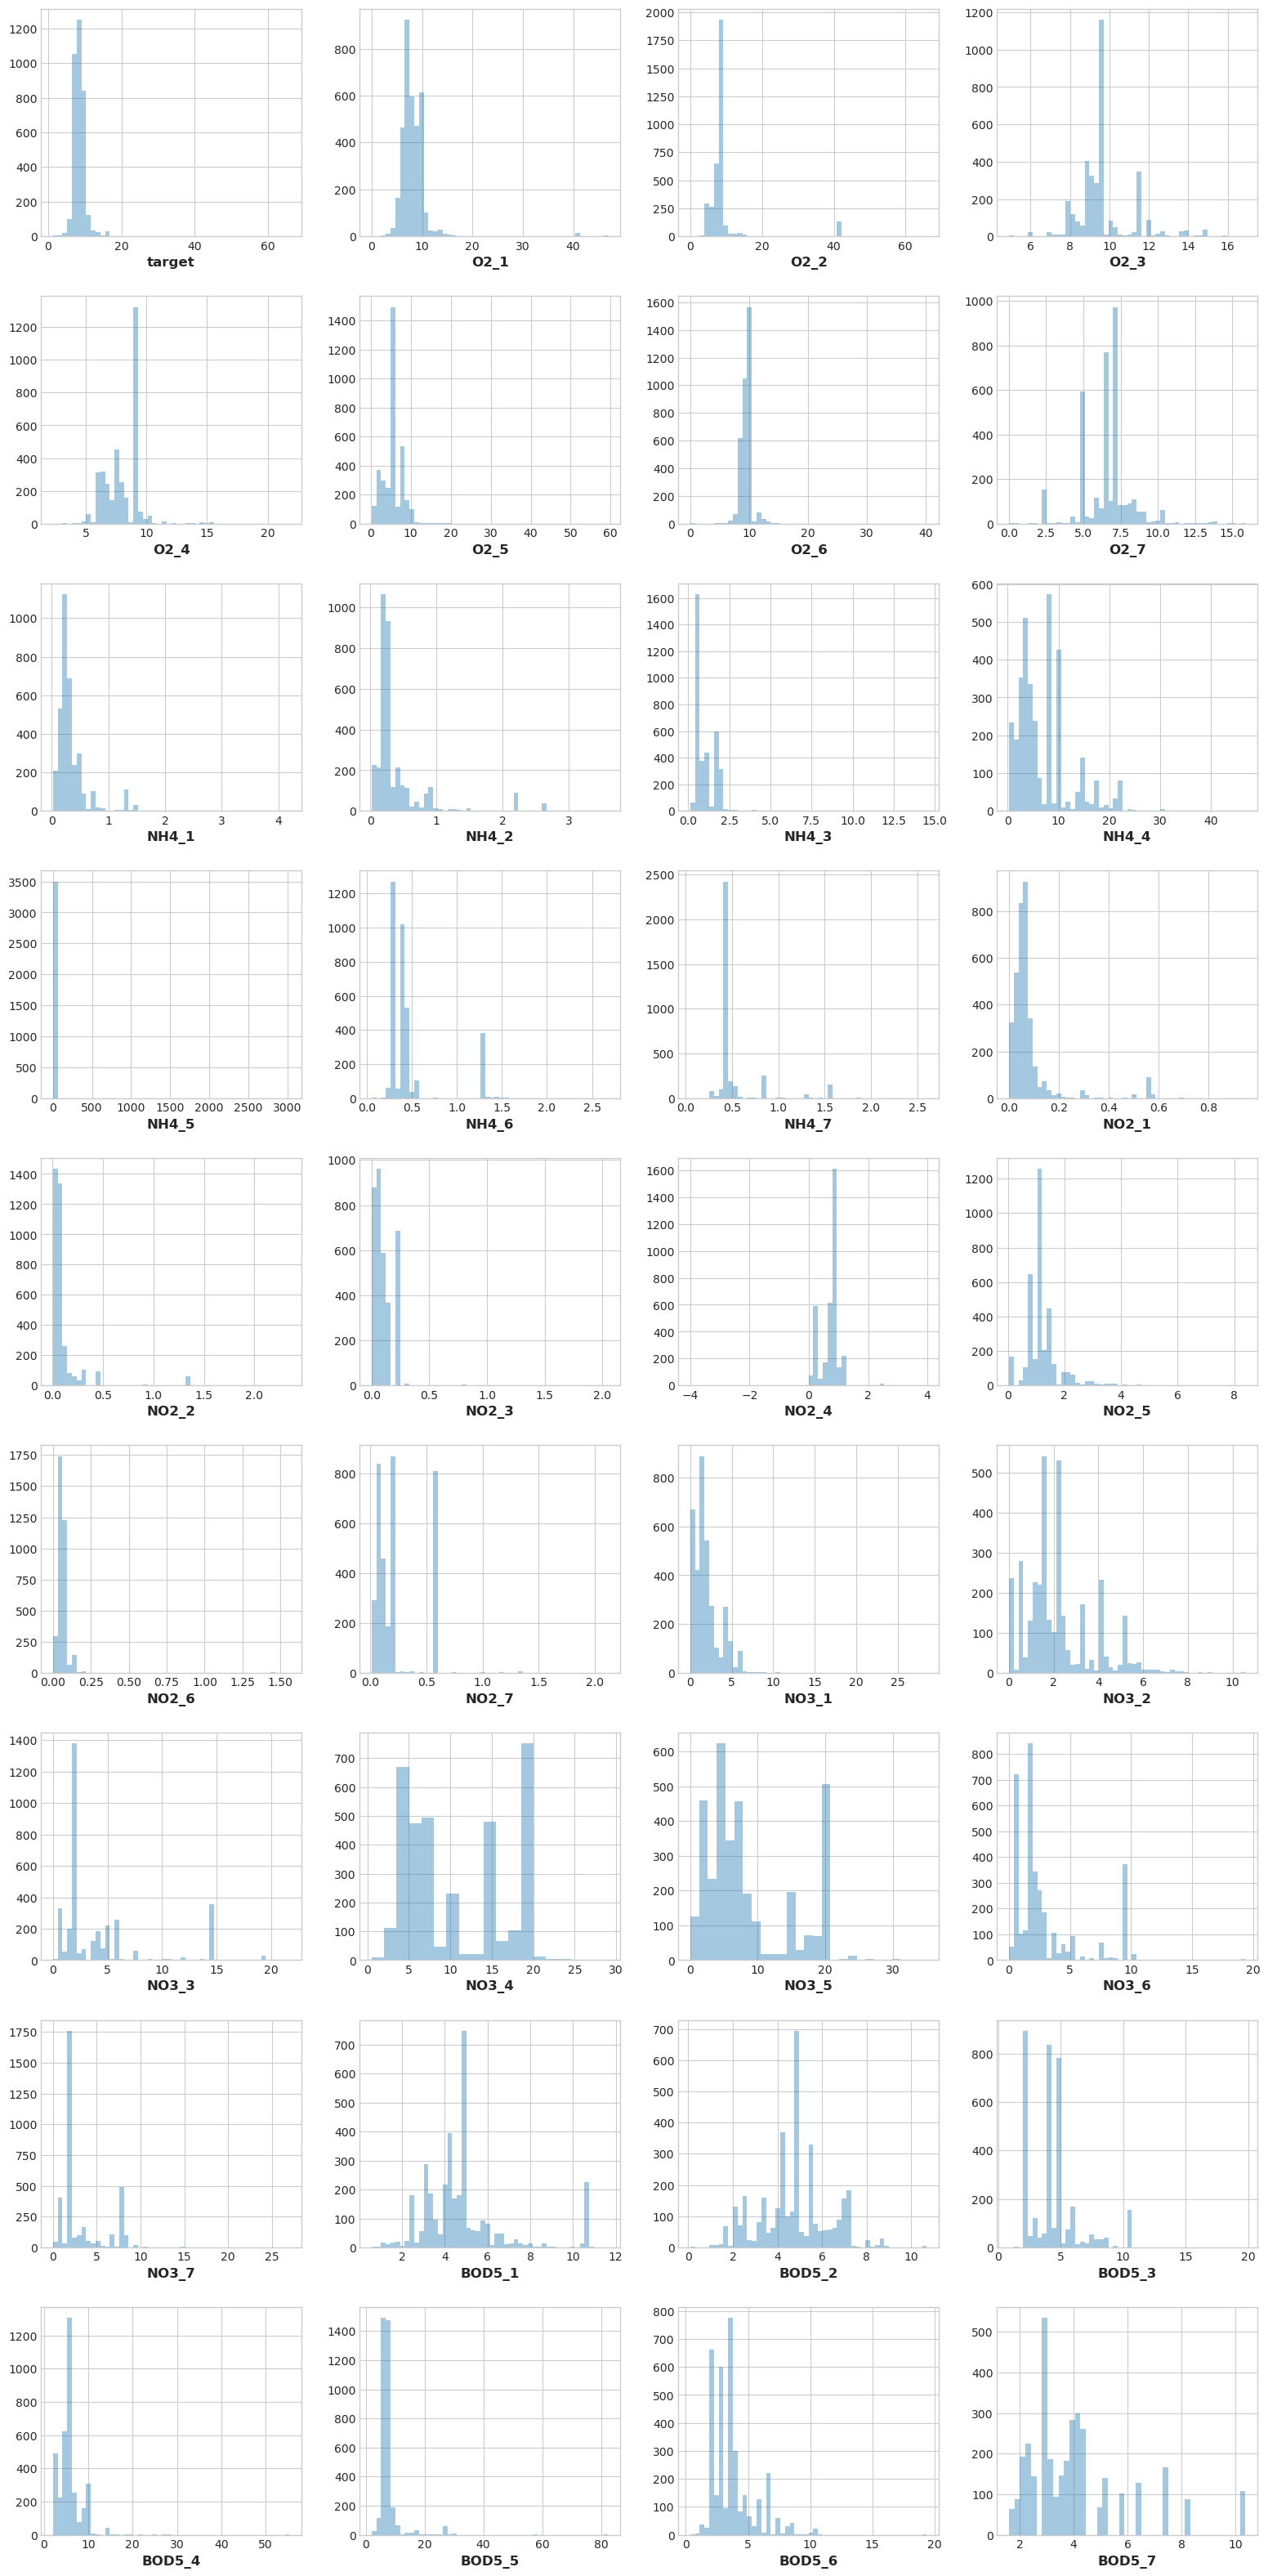

In [11]:
disc_num_var = ['id']

cont_num_var = []
for i in num_col.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

fig = plt.figure(figsize=(16,35))
for index,col in enumerate(cont_num_var):
    plt.subplot(10,4,index+1)
    sns.distplot(num_col.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=2.0)

This plot help us idenytify some variables with mostly 1 value as seen from the plots. Features with mostly 0s are highly *skewed*. Having alot of 0s in the distribution doesnt really add information for predicting problems. Hence, we can remove them during our preprocessing step.

### Boxplot to identify outliers

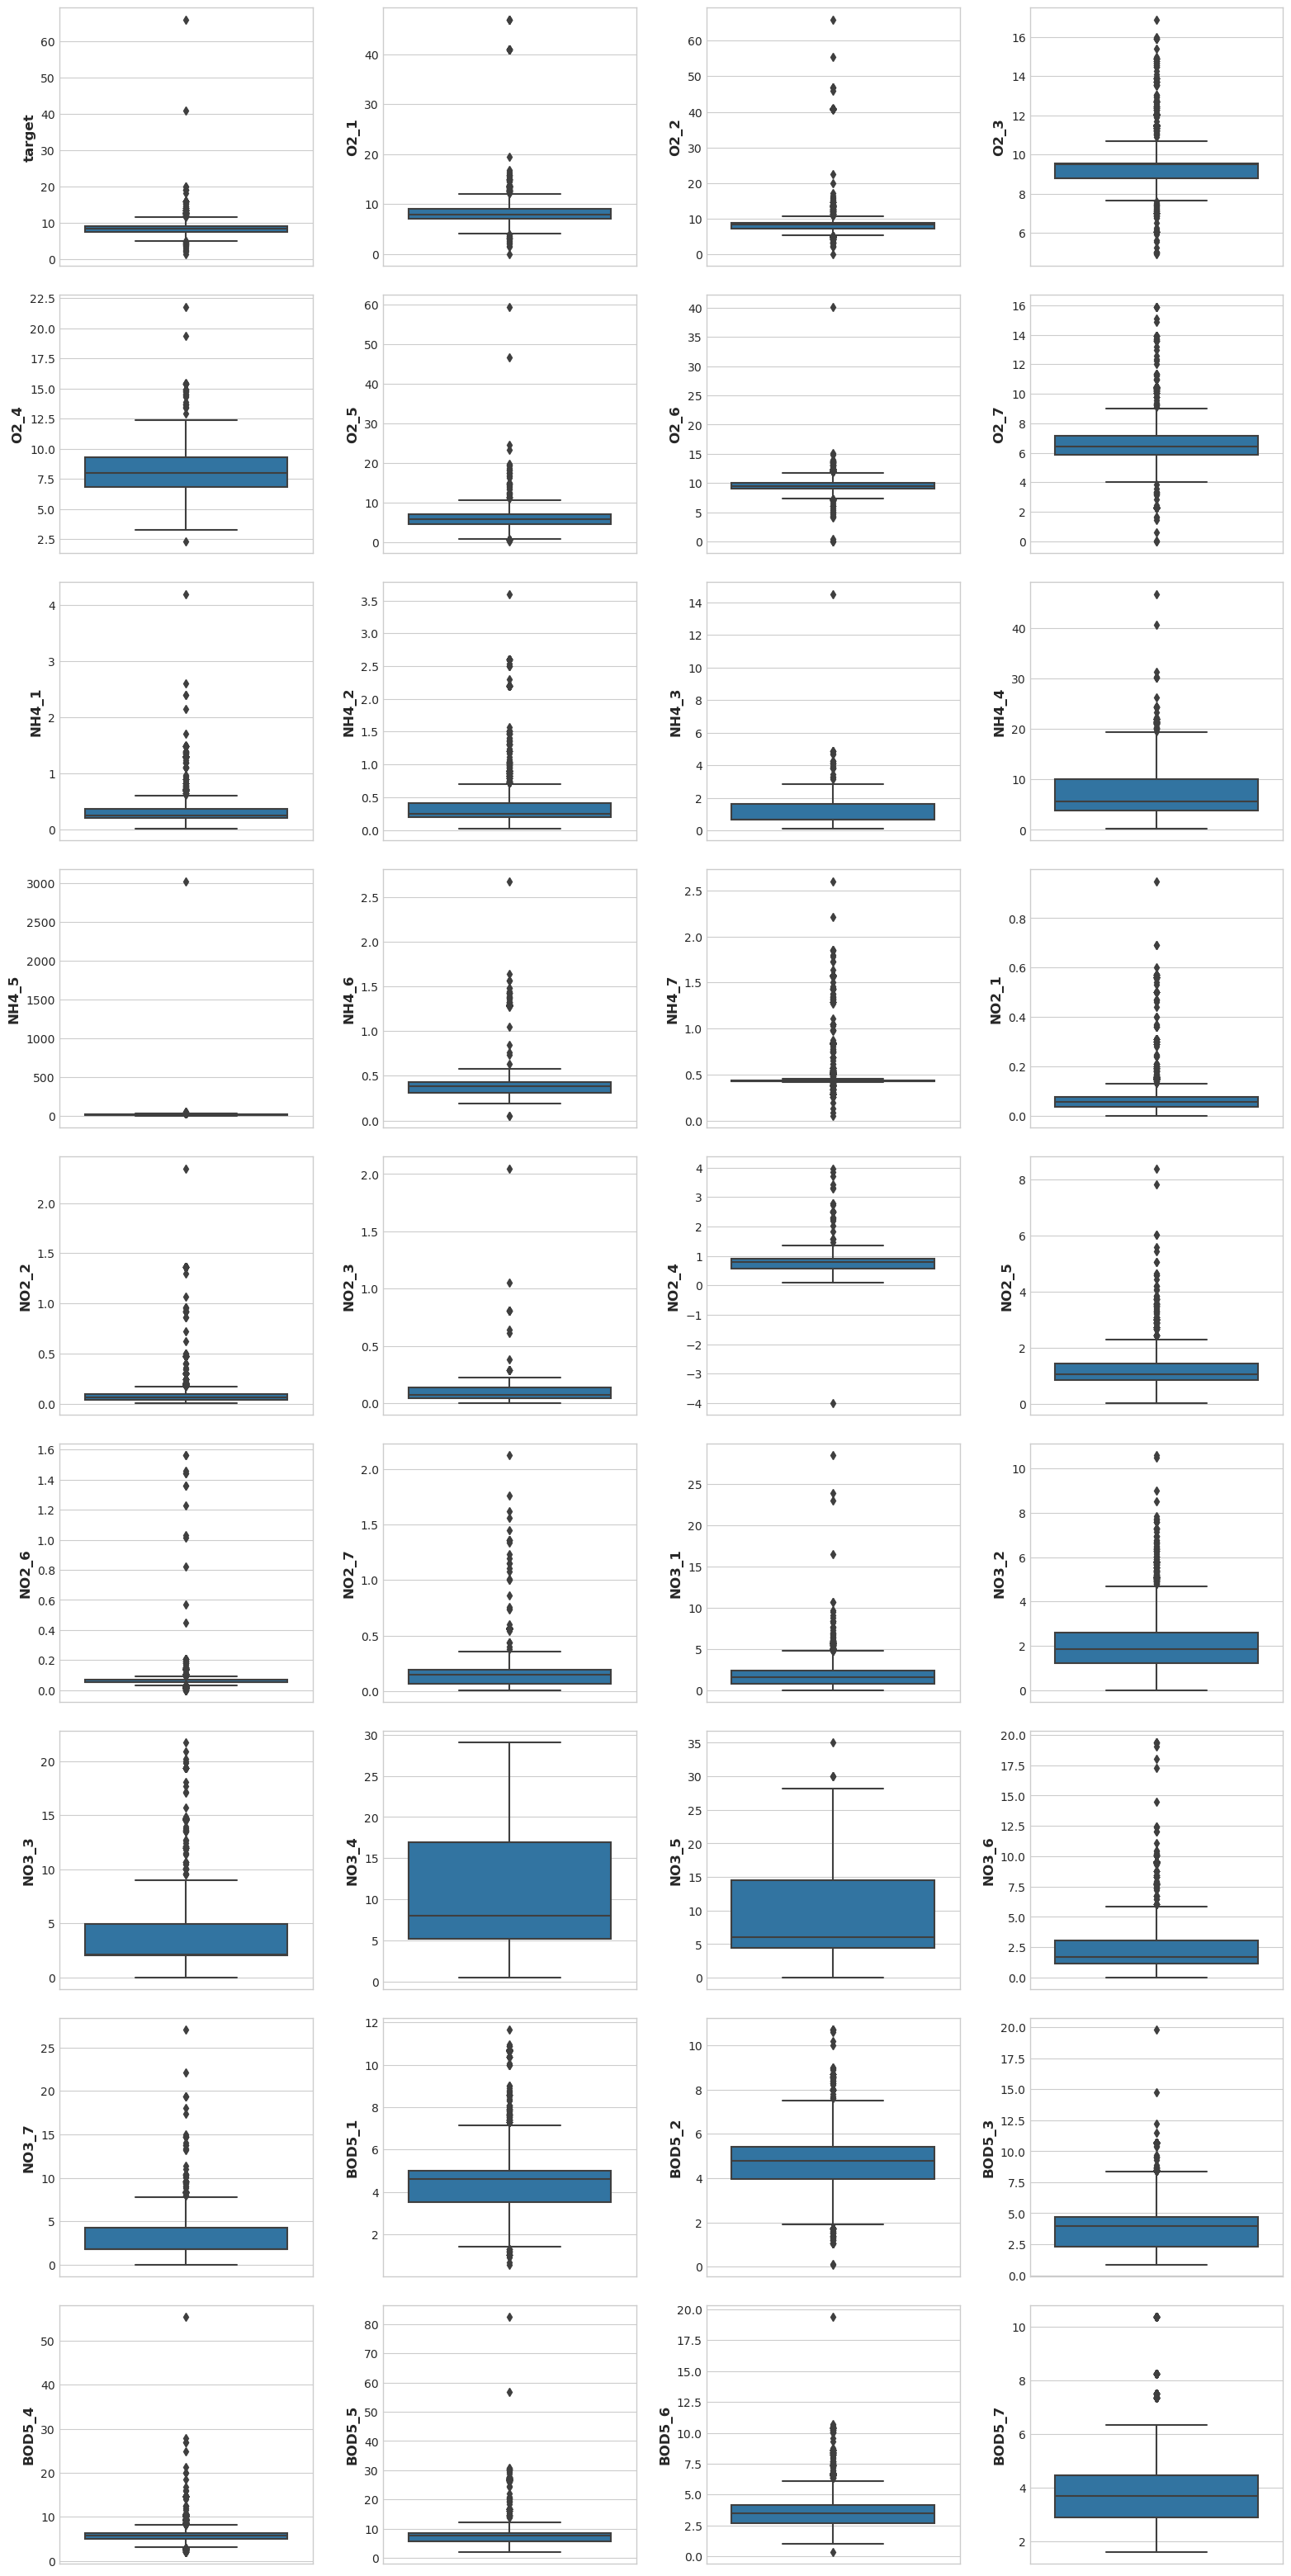

In [12]:
fig = plt.figure(figsize=(16,35))
for index,col in enumerate(cont_num_var):
    plt.subplot(10,4,index+1)
    sns.boxplot(y=col, data=num_col.dropna())
fig.tight_layout(pad=2.0)

In [13]:
# fig = plt.figure(figsize=(20,15))
# for index,col in enumerate(disc_num_var):
#     plt.subplot(10,3,index+1)
#     sns.countplot(x=col, data=num_col.dropna())
# fig.tight_layout(pad=1.0)

### Categorical features

In the case of categorical features, we will often use countplots to visualize the count of each distinct value within each features. We could find some categorical features that consist of mainly just one value, which does not add any useful information. Thus, we should also remove them later on.

In [14]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_col.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_col.iloc[:,index], data=cat_col.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=2.0)

<Figure size 1800x2000 with 0 Axes>

Univariate Analysis helps us to understand all the features better, on an individual scale. To further deepen our insights and uncover potential pattern in the data, we will also need to find out more about the relationship between all these features with one another, which brings us to our next step in our analysis - Bivariate Analysis

## Bi-Variate Analysis

Bi-variate analysis looks at 2 different features to identify any possible relationship or distinctive patterns between the 2 features. One of the commonly used technique is through the Correlation Matrix. Correlation matrix is an effective tool to uncover linear relationship (Correlation) between any 2 continuous features. Correlation not only allow us to determine which features are important to TARGET, but also as a mean to investigate any multicollinearity between our independent predictors.
Multicollinearity happens when 2 or more independent variables are highly correlated with one another. In such situation, it causes precision loss in our regression coefficients, affecting our ability to identify the most important features that are most useful to our model

### Correlation matrix

<Axes: >

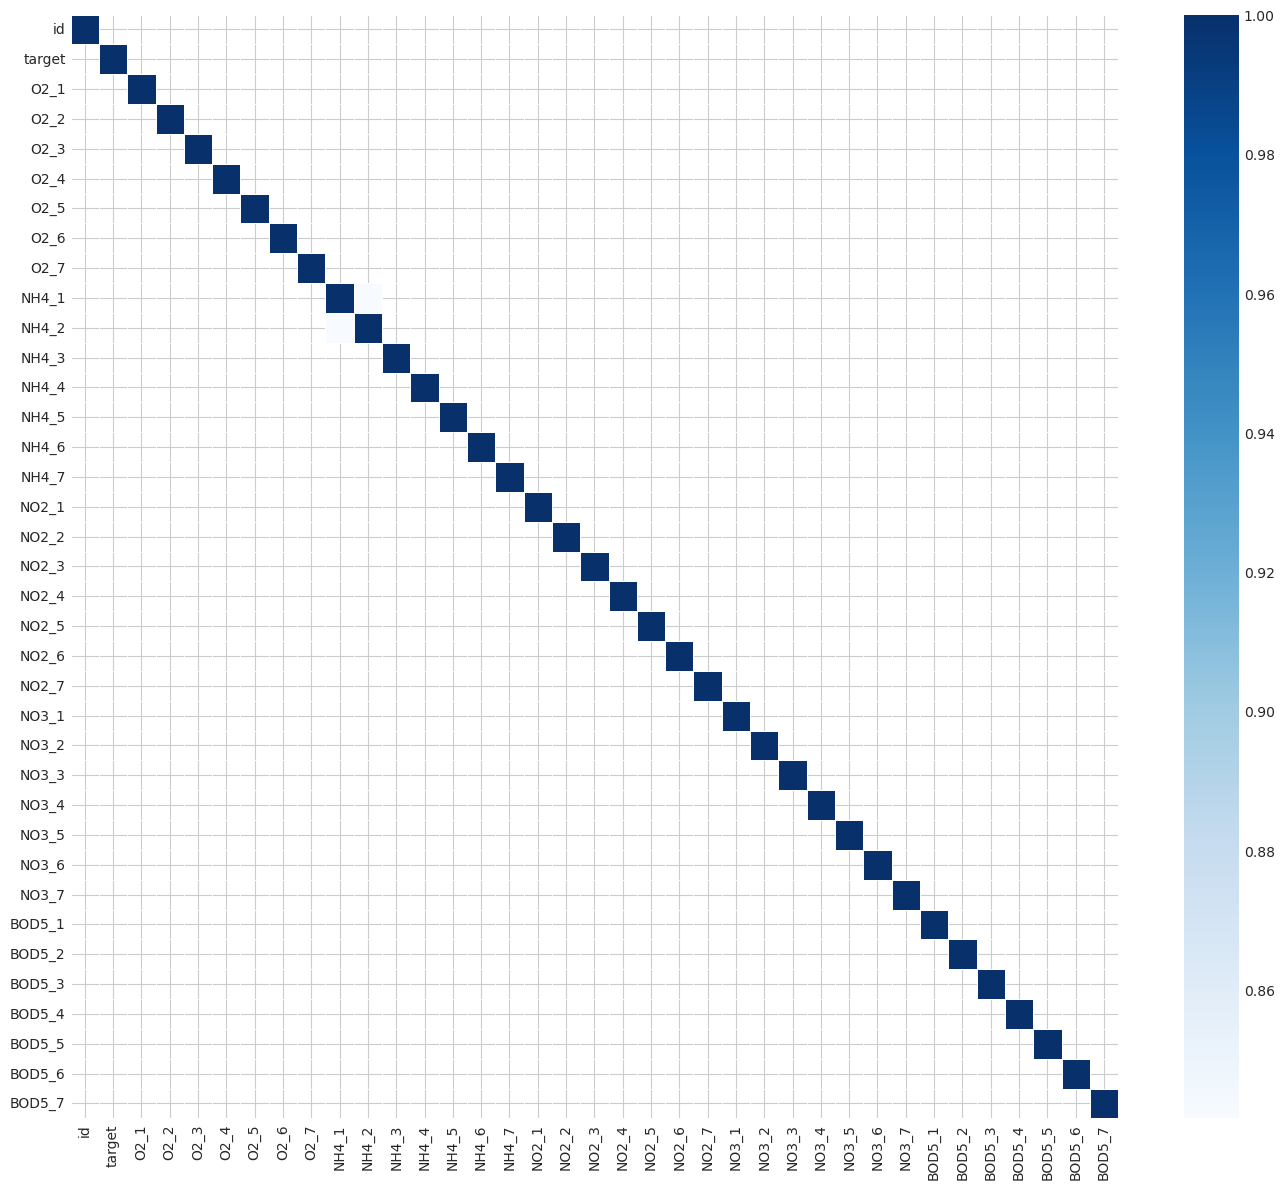

In [15]:
plt.figure(figsize=(14,12))
correlation = num_col.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

From the correlation matrix we didnt identify any variables which are highly correlated with each other. Otherwise it would guide us in our preprocessing steps later on as we aim to remove highly correlated features to avoid performance loss in our model

#### Identifying relationship between Numerical Predictor and Target

Below, we sorted the strength of linear relationship between TARGET and other features. Hence, these features will be important factor.

In [16]:
num_col_TARGET = train.select_dtypes(exclude=['object'])
correlation = num_col_TARGET.corr()
correlation[[TARGET]].sort_values([TARGET], ascending=False)

,target
target,1.000000
O2_1,0.481100
O2_2,0.222749
O2_6,0.068118
NH4_5,0.066669
O2_3,0.059053
O2_7,0.058312
NH4_4,0.048865
NO2_2,0.036352
NO3_2,0.034108


#### Scatterplot

Using scatterplot can also help us to identify potential linear relationship between Numerical features. Although scatterplot does not provide quantitative evidence on the strength of linear relationship between our features, it is useful in helping us to visualize any sort of relationship that correlation matrix could not calculate. E.g Quadratic, Exponential relationships.

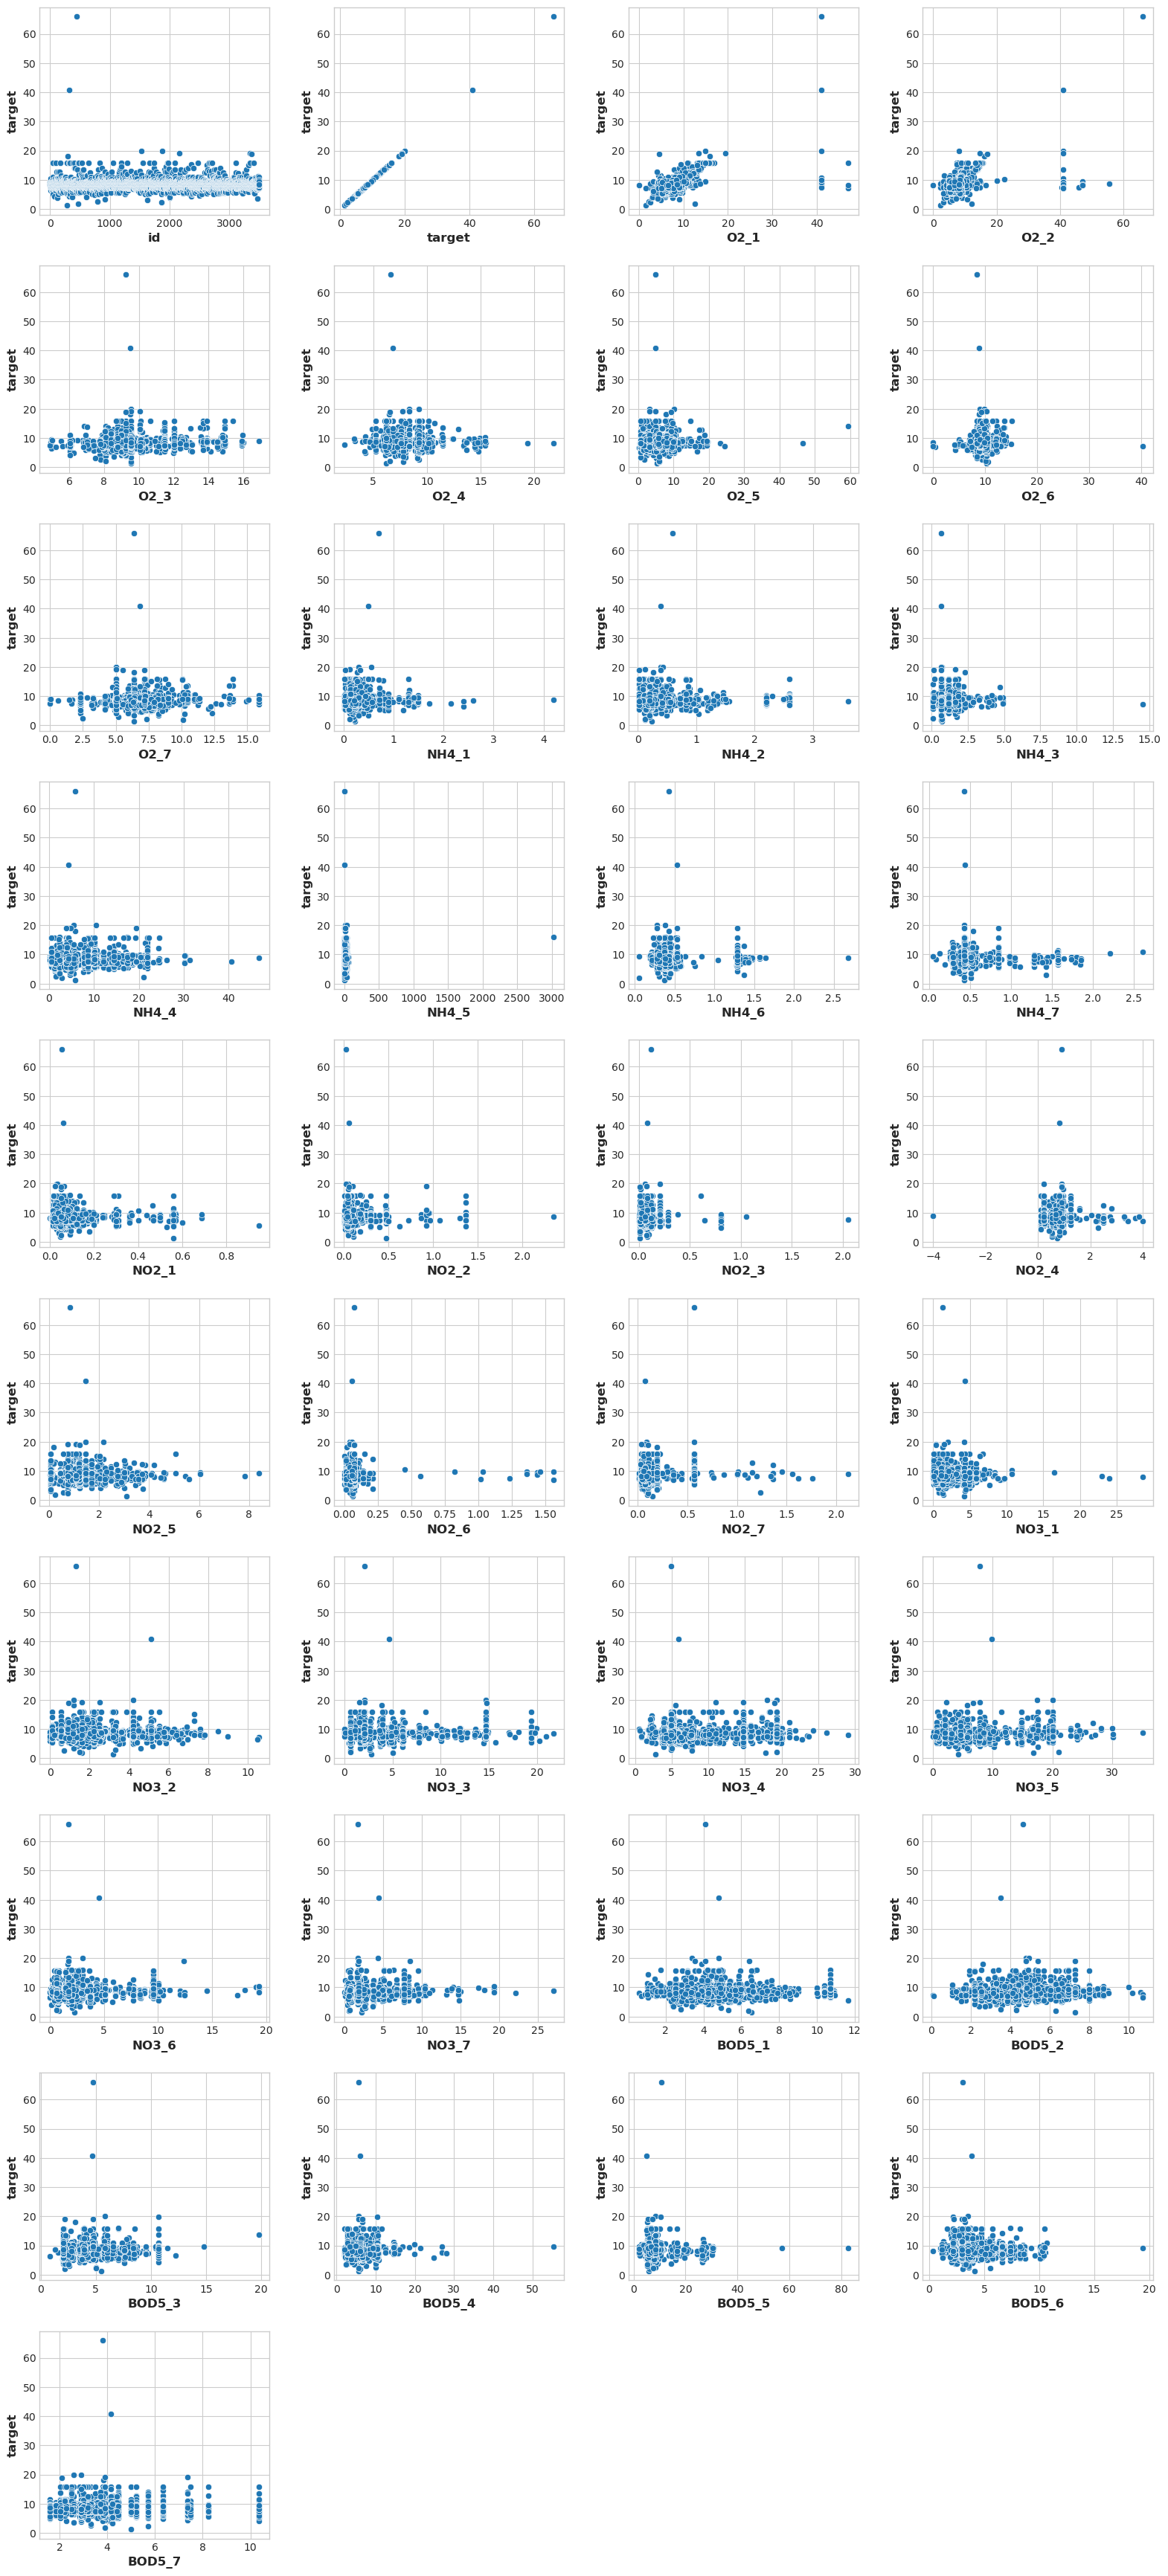

In [17]:
fig = plt.figure(figsize=(16,35))
for index in range(len(train.columns)):
    plt.subplot(10,4,index+1)
    sns.scatterplot(x=train.iloc[:,index], y=TARGET, data=train.dropna())
fig.tight_layout(pad=2.0)

### Mutual information

Mutual information describes relationships in terms of uncertainty. The mutual information between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships. Mutual information can capture any kind of association (not just linear, like correlation.)

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

Here are some things to remember when applying mutual information:

* MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
* It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
* The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [18]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_float_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [19]:
train.shape

(3500, 37)

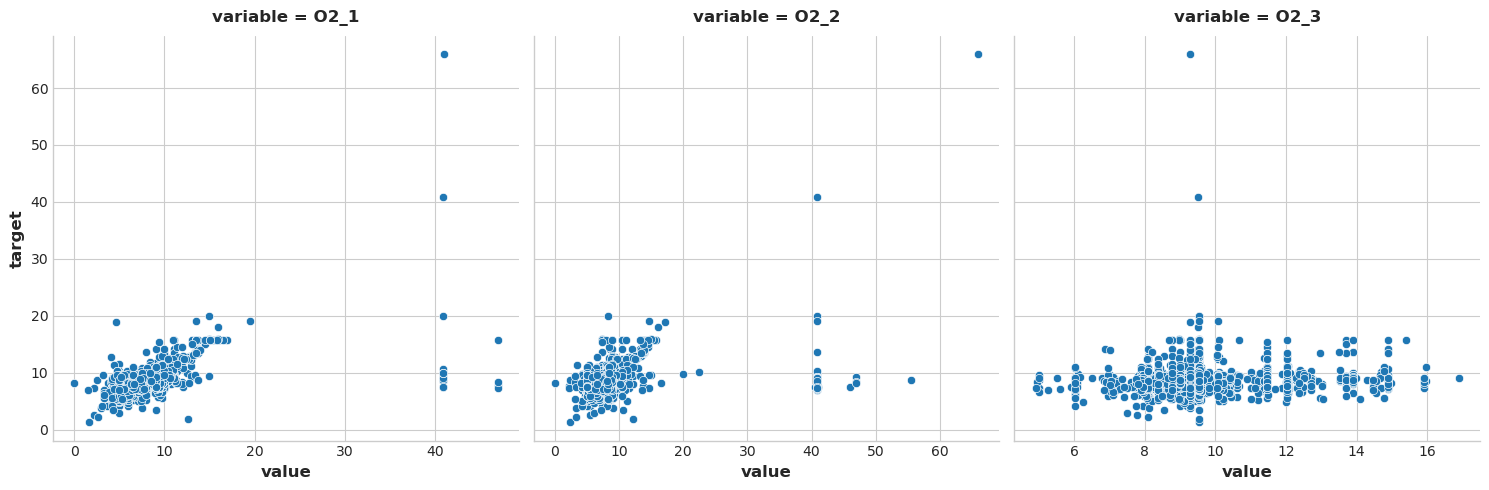

In [20]:
X_raw = train.fillna(method='ffill')
features = ['O2_1', 'O2_2', 'O2_3']
sns.relplot(
    x="value", y=TARGET, col="variable", data=X_raw.melt(id_vars=TARGET, value_vars=features), facet_kws=dict(sharex=False),
);

Based on the plots, which feature do you think would have the highest mutual information with *TARGET*?
The highest mutual information with *TARGET* tends to constrain it to a smaller range of possible values.

The dataset may have a lot of features to work with all at once! Fortunately, you can identify the features with the most potential.
We can compute mutual information scores for the dataset features.

In [21]:
X_mi = X_raw.copy()
y_mi = X_mi.pop(TARGET)

In [22]:
[X_mi.shape, y_mi.shape]

[(3500, 36), (3500,)]

In [23]:
mi_scores = make_mi_scores(X_mi, y_mi)

O2_1      0.706273
O2_2      0.488732
BOD5_2    0.169508
NO3_2     0.167166
BOD5_1    0.156936
O2_4      0.149669
NO2_3     0.136946
NO3_1     0.136410
NH4_1     0.132695
NH4_2     0.128456
O2_3      0.126310
BOD5_4    0.122686
NO2_1     0.118420
NO2_2     0.118249
BOD5_5    0.114159
O2_5      0.113747
O2_6      0.110747
NH4_3     0.110734
NO3_3     0.106885
NH4_4     0.104127
Name: MI Scores, dtype: float64


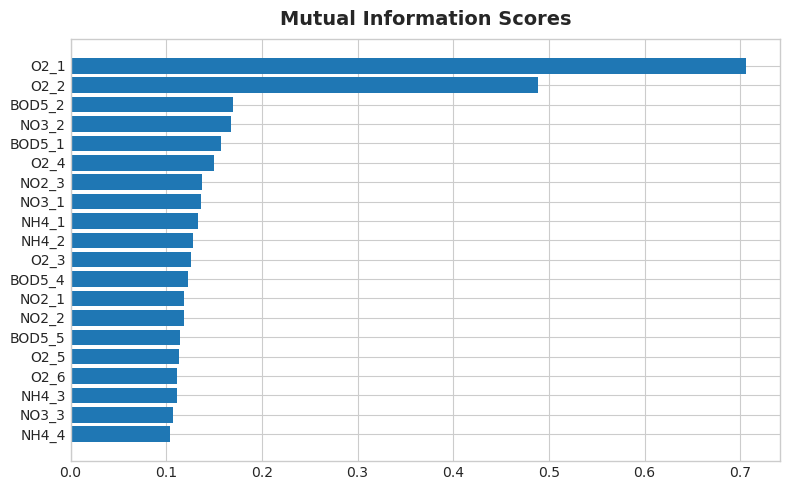

In [24]:
print(mi_scores.head(20))
#print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
#plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe?

It's good that our mutual information metric scored features highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant.

In [25]:
# sns.catplot(x="O2_1", y=TARGET, data=train, kind="boxen");

In [26]:
# feature = "O2_1"

# sns.lmplot(
#     x=feature, y=TARGET, hue="O2_1", col="O2_1",
#     data=train, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
# );

## Data Processing

In [27]:
X = train

## BaseLine

In [28]:
X.shape

(3500, 37)

In [29]:
def score_competition(submission, validation):
    """Simulate the scoring of a submission against the test set
    
    Return the validation RMSE"""
    rf = RandomForestRegressor(n_estimators=1000,
                               max_depth=7,
                               n_jobs=-1,
                               random_state=42)
    rf.fit(submission[all_col], submission.target)
    y_va_pred = rf.predict(validation[all_col])
    rmse = mean_squared_error(validation.target, y_va_pred, squared=False)
    return rmse

def cross_validate_model(prepare_submission, label):
    """Cross-validate the prepare_submission function
    
    Parameters:
    prepare_submission: function which transforms its argument sample_submission
    into a dataframe for submission
    
    label: label for the final comparison
    """
    rmse_list = []
    kf = KFold(shuffle=True, random_state=1)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X)):
        submission = prepare_submission(X.iloc[idx_tr].copy())
        rmse = score_competition(submission, X.iloc[idx_va])
        print(f"# Fold {fold} RMSE: {rmse:.3f}")
        rmse_list.append(rmse)

    rmse = np.sqrt(np.square(np.array(rmse_list)).mean())
    print(f"# Overall RMSE: {rmse:.3f} {label}")
    RESULT_BASELINE.append([label, rmse] + rmse_list)
    
cross_validate_model(lambda x: x, 'baseline')
# Overall RMSE: 1.574 baseline

# Fold 0 RMSE: 1.241
# Fold 1 RMSE: 1.112
# Fold 2 RMSE: 1.041
# Fold 3 RMSE: 0.993
# Fold 4 RMSE: 2.746
# Overall RMSE: 1.574 baseline


## Clip target

In [30]:
X.target = X.target.clip(lower = 7, upper = 20)

In [31]:
X.shape

(3500, 37)

## Redundant features

Now that we have more or less finished analysing our data and gaining insights through the various analysis and visualization, we will have to leverage on these insights to guide our preprocessing decision, so as to provide a clean and error-free data for our model to train on later on.

### Multicollinearity - highly correlated features

From the above correlation matrix, we can pinpointed certain features that are highly correlated that we will remove to avoid the problem of multicollinearity.

In [32]:
# X.drop(['Features 1','Features 2','Features 3','Features 4'], axis=1, inplace=True)

### Features with alot of missing values

Apart from these highly correlated features, we also can remove features that is not very useful in prediction due to many missing values that can provide any useful information.

<Axes: title={'center': 'Number of missing rows'}, xlabel='features', ylabel='sum'>

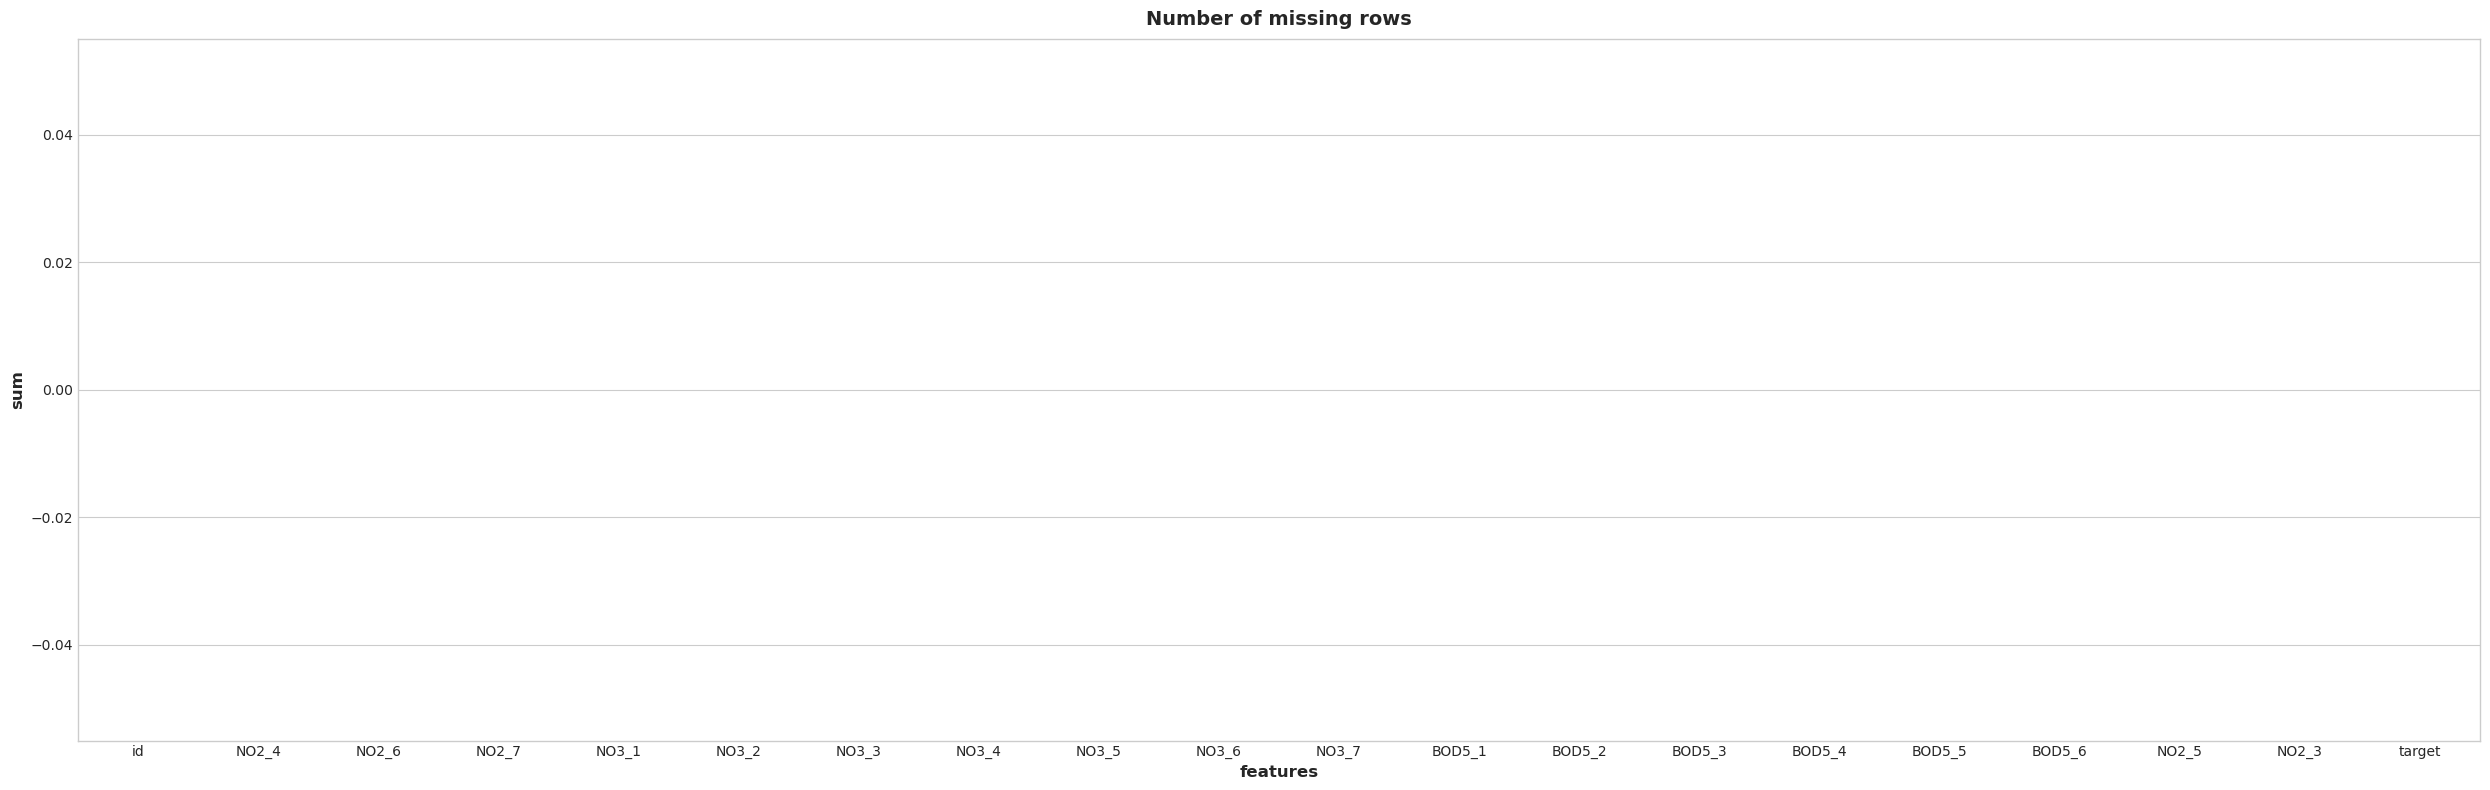

In [33]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

In [34]:
# X.drop(['','',''], axis=1, inplace=True)

In [35]:
# [X.shape, y.shape]

### Useless features

We can also remove features that does not have any linear relationship with target identified on the Correlation analysis.

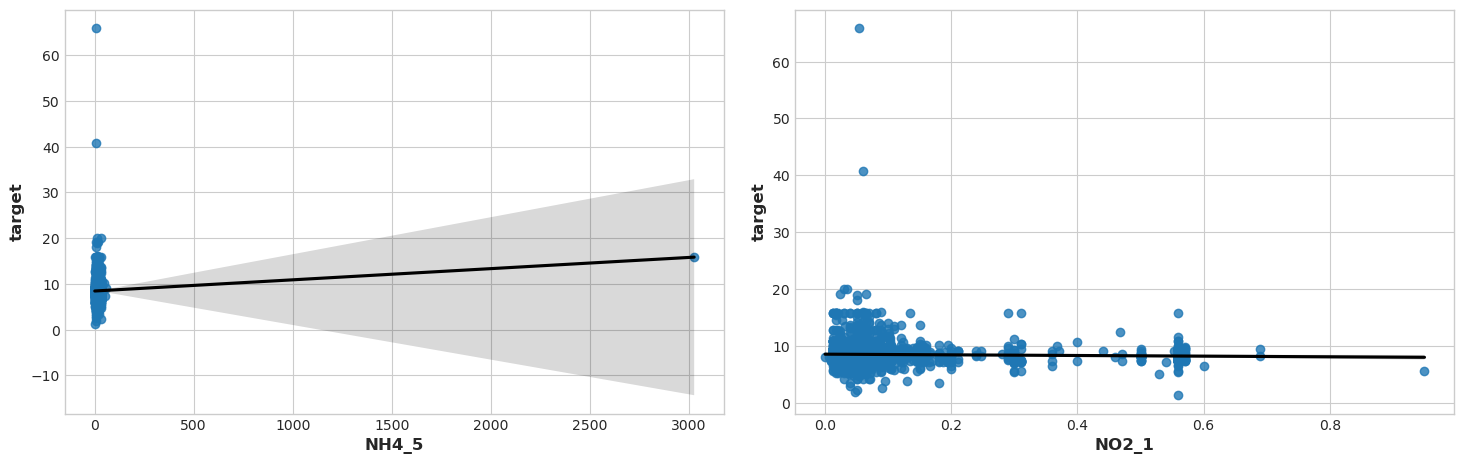

In [36]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=num_col_TARGET['NH4_5'], y=TARGET, data=num_col_TARGET, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=num_col_TARGET['NO2_1'], y=TARGET, data=num_col_TARGET, ax = axes[1], line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [37]:
correlation[[TARGET]].sort_values([TARGET], ascending=False).tail(10)

,target
NO3_6,-0.005423
NH4_3,-0.005626
BOD5_5,-0.009378
NO3_3,-0.010787
id,-0.014426
BOD5_7,-0.020524
NH4_7,-0.021345
BOD5_1,-0.030514
NO2_1,-0.032626
O2_4,-0.035554


In [38]:
# X.drop(['NO3_7',
# 'BOD5_6',	
# 'NO3_6',
# 'NH4_3',
# 'BOD5_5',
# 'NO3_3',
# 'BOD5_7',
# 'NH4_7',
# 'BOD5_1',
# 'NO2_1',
# 'O2_4'], axis=1, inplace=True)

In [39]:
X.shape

(3500, 37)

### Removing features that have mostly just 1 value

Earlier during our Univariate analysis, if we found that some features mostly consist of just a single value or 0s, which is not useful to us, we set a user defined threshold at 96% where if a column has more than 96% of the same value, we will render the features to be useless and remove it, since there isnt much information we can extract from

In [40]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
print(overfit_cat)

[]


In [41]:
# X = X.drop(overfit_cat, axis=1)

In [42]:
num_col = X.select_dtypes(exclude=['object']).copy()
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
print(overfit_num)

[]


In [43]:
# X = X.drop(overfit_num, axis=1)

In [44]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  []
Numerical Features with >96% of the same value:  []


### Dealing with duplicated values

In [45]:
print('Number of duplicated values in dataset: ', X.duplicated().sum())

Number of duplicated values in dataset:  0


In [46]:
#X.drop_duplicates(inplace=True)

## Dealing with outliers

Removing outliers will prevent our models performance from being affected by extreme values. From our boxplot earlier, we can pinpointed features with extreme outliers and remove the them based on certain threshold value.

In [47]:
def preprocess_outliers(data):
    svm = SGDOneClassSVM(nu=0.55)
    yhat = svm.fit_predict(data.drop('id', axis=1))
    mask = yhat != -1
    data_SVM = data.loc[mask, :].reset_index(drop=True)
   

    iso = IsolationForest(random_state=0)
    yhat = iso.fit_predict(data_SVM.drop('id', axis=1))
    mask = yhat != -1
    data_ISO = data_SVM.loc[mask, :].reset_index(drop=True)


    lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
    yhat = lof.fit_predict(data_ISO.drop(['id', 'target'], axis=1))
    mask = yhat != -1
    data_final = data_ISO.loc[mask, :].reset_index(drop=True)
  
    dp = np.random.choice(data_final[data_final[TARGET]==7].index.to_numpy(), 120, replace=False)
    return data_final.drop(dp)

X = preprocess_outliers(X)

In [48]:
X.shape

(2939, 37)

In [49]:
# out_col = ['','','','','']
# fig = plt.figure(figsize=(20,5))
# for index,col in enumerate(out_col):
#     plt.subplot(1,5,index+1)
#     sns.boxplot(y=col, data=X)
# fig.tight_layout(pad=1.5)

## Filling Missing Values

Machine learning model is unable to deal with missing values, thus we need to deal with them based on our understanding of the features. These missing values are denoted NAN as we have seen earlier during our data exploration.

In [50]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False)

,sum
id,0
NO2_4,0
NO2_6,0
NO2_7,0
NO3_1,0
NO3_2,0
NO3_3,0
NO3_4,0
NO3_5,0
NO3_6,0


### Ordinal features

We will replace the ordinal missing values with NA, which will be mapped later on when we encode them into an ordered arrangement

In [51]:
# X[ord_col] = X[ord_col].fillna("NA")

### Categorical features

We will replace the missing value of our categorical features with the most frequent occurrence (mode) of the individual features.

In [52]:
# X[cat_col] = X.groupby("CategoricalFeature")[cat_col].transform(lambda x: x.fillna(x.mode()[0]))

### Numerical features

For Numerical Features, the common approach will be to replace the missing value with the mean of the feature distribution. However, certain features have wide variance in their distribution.

In [53]:
# print("Mean of : ", X[''].mean())
# print("Mean of : ", X[''].mean())

In [54]:
# neigh_lot = X.groupby('')[''].mean().reset_index(name='')
# neigh_garage = X.groupby('')[''].mean().reset_index(name='')

# fig, axes = plt.subplots(1,2,figsize=(22,8))
# axes[0].tick_params(axis='x', rotation=90)
# sns.barplot(x='', y='', data=neigh_lot, ax=axes[0])
# axes[1].tick_params(axis='x', rotation=90)
# sns.barplot(x='', y='', data=neigh_garage, ax=axes[1])

In [55]:
# #for correlated relationship
# X[''] = X.groupby('')[''].transform(lambda x: x.fillna(x.mean()))

# #numerical
# X[num_col] = X[num_col] = X[num_col].fillna(X[num_col].mean())

### Mapping ordinal features

May there are some columns which are ordinal by nature, which represents the quality or condition of certain features. We can map the respective strings to a value. The better the quality, the higher the value.

In [56]:
X.head

<bound method NDFrame.head of         id  target    O2_1    O2_2    O2_3   O2_4   O2_5    O2_6   O2_7  \
0        0    8.59   7.500   9.000   9.545  9.265  8.110   8.430  7.150   
1        1    9.10  13.533  40.900   8.770  9.265  6.015  10.070  7.150   
2        2    8.21   3.710   5.420   8.770  9.265  4.550  10.070  7.150   
3        3    8.39   8.700   8.100   9.500  9.200  5.200   8.670  6.670   
4        4    8.07   8.050   8.650   7.960  9.265  3.290  10.070  7.150   
...    ...     ...     ...     ...     ...    ...    ...     ...    ...   
3054  3494    8.65   8.367   8.760  13.900  9.265  9.930  10.400  7.150   
3055  3495    8.08   6.250   8.300   7.795  9.265  5.690   8.555  6.335   
3056  3496    8.09   6.630   6.630   8.370  7.600  0.636   8.430  7.150   
3057  3497    9.95   8.367   8.433   8.770  6.170  5.800  10.400  7.200   
3058  3499    8.51   8.500   8.100   9.545  9.265  8.110   9.805  7.150   

      NH4_1  ...   NO3_5  NO3_6  NO3_7  BOD5_1  BOD5_2  BOD5_3  BOD5_

In [57]:
# ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
# fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
# expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
# fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [58]:
# for col in ord_col:
#     X[col] = X[col].map(ordinal_map)
    
# fin_col = ['','']
# for col in fin_col:
#     X[col] = X[col].map(fintype_map)

# X[''] = X[''].map(expose_map)
# X[''] = X[''].map(fence_map)

In [59]:
# cols = X.select_dtypes(np.number).drop(['id', TARGET], axis=1).columns

# for i in cols:
#     X[i]=RobustScaler().fit_transform(X[i].values.reshape(-1,1))

# transformer = RobustScaler().fit(X[cols])
# X[cols] = transformer.transform(X[cols])

## Remove bad labels

In [60]:
def remove_bad_lbs(X, bad_lbs):
    return X[~X['id'].isin(bad_lbs)]

In [61]:
X = remove_bad_lbs(X,[2365, 1089, 1936, 1680, 211, 2294, 448, 437, 309,1684])

In [62]:
X.shape

(2930, 37)

## Set useless features to zero

We can also disable features that does not have any linear relationship with target identified on the Correlation analysis.

In [63]:
selected_features = ['id','target','O2_1', 'O2_2', 'BOD5_5', 'NH4_1']
for i in X.columns:
    if i not in selected_features:
        X[i] = 0

In [64]:
X.shape

(2930, 37)

# Feature Engineering <a class="anchor"  id="chapter2"></a>

After removing the outliers, highly correlated features and imputing missing values, we can now proceed with adding additional information for our model to train on. This is done by the means of - Feature Engineering.

## Creating Features

In [65]:
# def mathematical_transforms(df):
#     X = pd.DataFrame()
#     #...
#     return X


# def interactions(df):
#     X = pd.get_dummies(df., prefix="")
#     X = X.mul(df., axis=0)
#     return X


# def counts(df):
#     X = pd.DataFrame()
#     X[""] = df[[
#         "",
#         "",
#     ]].gt(0.0).sum(axis=1)
#     return X


# def break_down(df):
#     X = pd.DataFrame()
#     X[""] = df. .str.split("_", n=1, expand=True)[0]
#     return X


# def group_transforms(df):
#     X = pd.DataFrame()
#     X[""] = df.groupby("")[""].transform("median")
#     return X

# def label_encode(df):
#     X = df.copy()
#     for colname in X.select_dtypes(["category"]):
#         X[colname] = X[colname].cat.codes
#     return X

## Skewed target

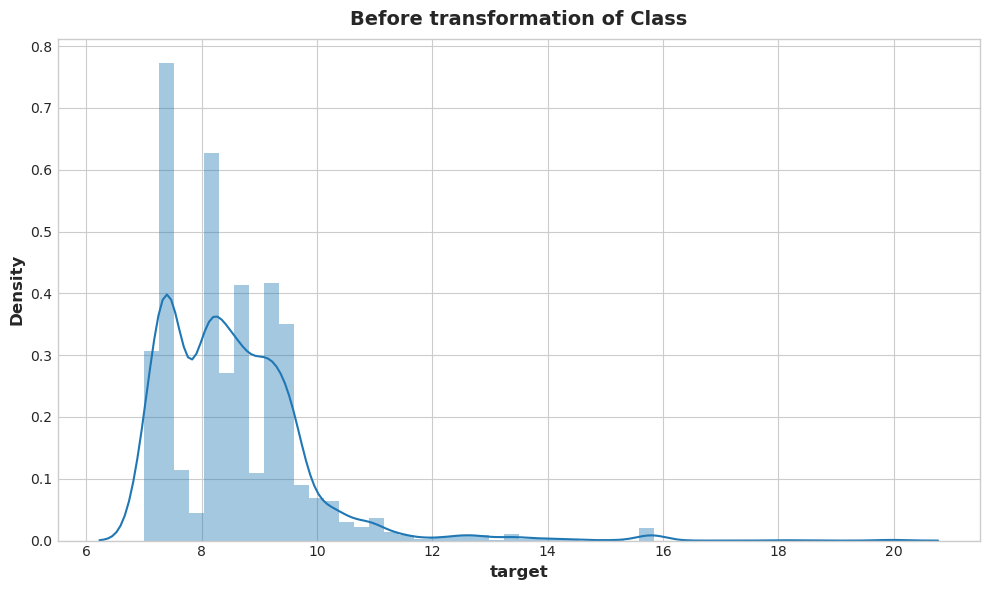

In [66]:
# before transforation
plt.figure(figsize=(10,6))
plt.title("Before transformation of Class")
dist = sns.distplot(X[TARGET],norm_hist=False)

Distribution is skewed to the right, where the tail on the curve’s right-hand side is longer than the tail on the left-hand side, and the mean is greater than the mode. This situation is also called positive skewness.
Having a skewed target will affect the overall performance of our machine learning model, thus, one way to alleviate will be to using log transformation on skewed target reducing the skewness of the distribution.

In [67]:
# X[TARGET] = np.log(X[TARGET])

In [68]:
# # after transforation
# plt.figure(figsize=(10,6))
# plt.title("After transformation of Class")
# dist = sns.distplot(np.log(X[TARGET]),norm_hist=False)

## Clustering K-Means or Cluster-distance

Clustering simply means the assigning of data points to groups based upon how similar the points are to each other. A clustering algorithm makes "birds of a feather flock together," so to speak.

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

In [69]:
cluster_features = [
    "",
    ""
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

def plot_cluester(X):
    Xy = X.copy()
    Xy["Cluster"] = Xy.Cluster.astype("category")
    Xy[TARGET] = y
    sns.relplot(
        x="value", y=TARGET, hue="Cluster", col="variable",
        height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
        data=Xy.melt(
            value_vars=features, id_vars=[TARGET, "Cluster"],
        ),
    );

In [70]:
# plot_cluester(X)

## PCA

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features.

PCA Best Practices
* There are a few things to keep in mind when applying PCA:
* PCA only works with numeric features, like continuous quantities or counts.
* PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
* Consider removing or constraining outliers, since they can have an undue influence on the results.

Let's choose a few features that are highly correlated with our target.

In [71]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [72]:
# #Let's choose a few features that are highly correlated with our target, SalePrice.
# pca_features = [
#     "Amount"
# ]

# def pca_inspired(df):
#     X = pd.DataFrame()
#     X["Amount"] = df.Amount + df.
#     X["Amount"] = df. * df.
#     return X


# def pca_components(df, pca_features):
#     X = df.loc[:, pca_features]
#     _, X_pca, _ = apply_pca(X)
#     return X_pca

In [73]:
# def corrplot(df, method="pearson", annot=True, **kwargs):
#     sns.clustermap(
#         df.corr(method),
#         vmin=-1.0,
#         vmax=1.0,
#         cmap="icefire",
#         method="complete",
#         annot=annot,
#         **kwargs,
#     )

# corrplot(df_train, annot=None)

In [74]:
# def indicate_outliers(df):
#     X_new = pd.DataFrame()
#     X_new["Outlier"] = (df. == "") & (df. == "")
#     return X_new

## Target Encoding

Target encoding, is instead meant for categorical features. It's a method of encoding categories as numbers, like one-hot or label encoding, with the difference that it also uses the target to create the encoding. This makes it what we call a supervised feature engineering technique.

A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.

There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:

1. Split the data into folds, each fold having two splits of the dataset.
1. Train the encoder on one split but transform the values of the other.
1. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In [75]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

Usage:

In [76]:
# encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
# X_encoded = encoder.fit_transform(X, y, cols=["", ""])

In [77]:
# X_encoded.head()

In [78]:
# X_encoded_t = encoder.transform(test)

In [79]:
# X_encoded_t

In [80]:
X.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,0,0,0,0,0.180,...,0,0,0,0,0,0,0,16.645,0,0
1,1,9.10,13.533,40.90,0,0,0,0,0,1.107,...,0,0,0,0,0,0,0,5.725,0,0
2,2,8.21,3.710,5.42,0,0,0,0,0,0.020,...,0,0,0,0,0,0,0,6.750,0,0
3,3,8.39,8.700,8.10,0,0,0,0,0,0.280,...,0,0,0,0,0,0,0,8.670,0,0
4,4,8.07,8.050,8.65,0,0,0,0,0,0.360,...,0,0,0,0,0,0,0,8.400,0,0


In [81]:
# X['Amount'] = X_encoded['Amount_encoded']
# X['Time'] = X_encoded['Time_encoded']

In [82]:
# X = X.join(X_encoded)
# test = test.join(X_encoded_t)

In [83]:
# X.head()

In [84]:
# test

### Scaling Manual or by Pipeline

RobustScaler is a transformation technique that removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It is also robust to outliers, which makes it ideal for data where there are too many outliers that will drastically reduce the number of training data.

Fit RobustScaler on both Train and Test set is a mistake. By fitting the scaler on both train and test set, we exposed ourselves to the problem of Data Leakage. Data Leakage is a problem when information from outside the training dataset is used to create the model. If we fit the scaler on both training and test data, our training data characteristics will contain the distribution of our testset. As such, we are unknowningly passing in information about our test data into the final training data for training, which will not give us the opportunity to truly test our model on data it has never seen before.
Fit the scaler just on training data, and then transforming it on both training and test data

If a distributions are very different for train and test set. This could cause serious problem, because the algorithm will be able to distinct between those sets more easily.

We can convert the features by breaking it down into an hour of the dayfeature or drop it.

In [85]:
# X = X.drop('', axis=1)
# test = test.drop('', axis=1)

In [86]:
X.head(10)

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,0,0,0,0,0.180,...,0,0,0,0,0,0,0,16.645,0,0
1,1,9.10,13.533,40.90,0,0,0,0,0,1.107,...,0,0,0,0,0,0,0,5.725,0,0
2,2,8.21,3.710,5.42,0,0,0,0,0,0.020,...,0,0,0,0,0,0,0,6.750,0,0
3,3,8.39,8.700,8.10,0,0,0,0,0,0.280,...,0,0,0,0,0,0,0,8.670,0,0
4,4,8.07,8.050,8.65,0,0,0,0,0,0.360,...,0,0,0,0,0,0,0,8.400,0,0
5,5,8.12,9.000,9.00,0,0,0,0,0,0.240,...,0,0,0,0,0,0,0,8.400,0,0
6,6,8.12,7.500,8.50,0,0,0,0,0,0.300,...,0,0,0,0,0,0,0,16.645,0,0
7,7,7.65,7.350,8.10,0,0,0,0,0,0.300,...,0,0,0,0,0,0,0,8.400,0,0
9,9,9.38,7.400,8.40,0,0,0,0,0,0.140,...,0,0,0,0,0,0,0,8.415,0,0
10,10,8.09,8.100,8.30,0,0,0,0,0,0.425,...,0,0,0,0,0,0,0,6.025,0,0


In [87]:
cols = X.select_dtypes(np.number).drop(['id', TARGET], axis=1).columns

transformer = RobustScaler().fit(X[cols])
X[cols] = transformer.transform(X[cols])

# #test[cols] = transformer.transform(test[cols])

In [88]:
#cols

In [89]:
X.head(10)

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,-0.222051,0.538462,0.0,0.0,0.0,0.0,0.0,-0.462069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.530841,0.0,0.0
1,1,9.10,2.871795,25.076923,0.0,0.0,0.0,0.0,0.0,5.931034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.551402,0.0,0.0
2,2,8.21,-2.165641,-2.215385,0.0,0.0,0.0,0.0,0.0,-1.565517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.168224,0.0,0.0
3,3,8.39,0.393333,-0.153846,0.0,0.0,0.0,0.0,0.0,0.227586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.549533,0.0,0.0
4,4,8.07,0.060000,0.269231,0.0,0.0,0.0,0.0,0.0,0.779310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.0
5,5,8.12,0.547179,0.538462,0.0,0.0,0.0,0.0,0.0,-0.048276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.0
6,6,8.12,-0.222051,0.153846,0.0,0.0,0.0,0.0,0.0,0.365517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.530841,0.0,0.0
7,7,7.65,-0.298974,-0.153846,0.0,0.0,0.0,0.0,0.0,0.365517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.0
9,9,9.38,-0.273333,0.076923,0.0,0.0,0.0,0.0,0.0,-0.737931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454206,0.0,0.0
10,10,8.09,0.085641,0.000000,0.0,0.0,0.0,0.0,0.0,1.227586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.439252,0.0,0.0


or pipeline

In [90]:
features_num = X.select_dtypes(exclude=['object']).copy().columns
features_cat = X.select_dtypes(include=['object']).copy().columns

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    #StandardScaler(),
    RobustScaler()
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [91]:
X.shape

(2930, 37)

## Predict

In [92]:
X

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,-0.222051,0.538462,0.0,0.0,0.0,0.0,0.0,-0.462069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.530841,0.0,0.0
1,1,9.10,2.871795,25.076923,0.0,0.0,0.0,0.0,0.0,5.931034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.551402,0.0,0.0
2,2,8.21,-2.165641,-2.215385,0.0,0.0,0.0,0.0,0.0,-1.565517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.168224,0.0,0.0
3,3,8.39,0.393333,-0.153846,0.0,0.0,0.0,0.0,0.0,0.227586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.549533,0.0,0.0
4,4,8.07,0.060000,0.269231,0.0,0.0,0.0,0.0,0.0,0.779310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,3494,8.65,0.222564,0.353846,0.0,0.0,0.0,0.0,0.0,3.262069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454206,0.0,0.0
3055,3495,8.08,-0.863077,0.000000,0.0,0.0,0.0,0.0,0.0,2.193103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185047,0.0,0.0
3056,3496,8.09,-0.668205,-1.284615,0.0,0.0,0.0,0.0,0.0,7.262069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454206,0.0,0.0
3057,3497,9.95,0.222564,0.102308,0.0,0.0,0.0,0.0,0.0,1.262069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.0


In [93]:
X.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,-0.222051,0.538462,0.0,0.0,0.0,0.0,0.0,-0.462069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.530841,0.0,0.0
1,1,9.10,2.871795,25.076923,0.0,0.0,0.0,0.0,0.0,5.931034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.551402,0.0,0.0
2,2,8.21,-2.165641,-2.215385,0.0,0.0,0.0,0.0,0.0,-1.565517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.168224,0.0,0.0
3,3,8.39,0.393333,-0.153846,0.0,0.0,0.0,0.0,0.0,0.227586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.549533,0.0,0.0
4,4,8.07,0.060000,0.269231,0.0,0.0,0.0,0.0,0.0,0.779310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.0


In [94]:
X.shape

(2930, 37)

In [95]:
cross_validate_model(lambda x: x, 'FINAL')

# Fold 0 RMSE: 0.897
# Fold 1 RMSE: 1.015
# Fold 2 RMSE: 0.905
# Fold 3 RMSE: 0.922
# Fold 4 RMSE: 0.827
# Overall RMSE: 0.915 FINAL


0.907< 0.917 >0.919

In [96]:
RESULT_BASELINE[0]

['baseline',
 1.5740354739905635,
 1.2410862622364742,
 1.1115296491362292,
 1.0410966926401746,
 0.992594027126453,
 2.746455874316764]

In [97]:
RESULT_BASELINE[1]

['FINAL',
 0.9151371828777797,
 0.8969634718258922,
 1.0146261741396534,
 0.9049029685598886,
 0.9222074174576717,
 0.8270759765981106]

# Save test predictions to file

In [98]:
X.to_csv('submission.csv',index=False)